In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
from sklearn.cross_validation import KFold
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')


In [19]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 20

# 学習の繰り返し回数
n_epoch = 50

# 中間層の数
n_units = 20


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/secondary_selection/input_data2_2"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:16])
                target_set.append(line[16])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
#N = 300
#x_train, x_test = np.split( data, [N])  
#y_train, y_test = np.split( target, [N]) 
#N_test = y_test.size
#print data
#print target



In [20]:
# 多層パーセプトロンモデルの設定
# 入力 15次元、出力 2次元
model = FunctionSet(l1=F.Linear(15, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, n_units),
                    l4=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.4, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.4, train=train)
        h3 = F.dropout(F.relu(model.l3(h2)), ratio=.4, train=train)
        y = model.l4(h3)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
   
                                
        #print '-'*50
        #print ' h3'
        #print '-'*50
        #print vars(h3)
                        
        #print '-'*50
        #print ' y'
        #print '-'*50
        #print vars(y)
 
        
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t), F.recall(y, t), F.precision(y, t)



In [21]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
train_rec = []
train_pre = []
test_loss = []
test_acc = []
test_rec = []
test_pre = []

l1_W = []
l2_W = []
l3_W = []
l4_W = []



[]

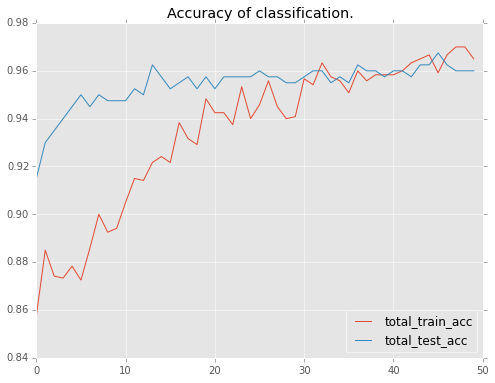

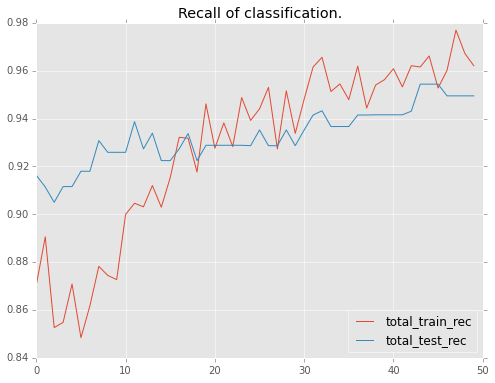

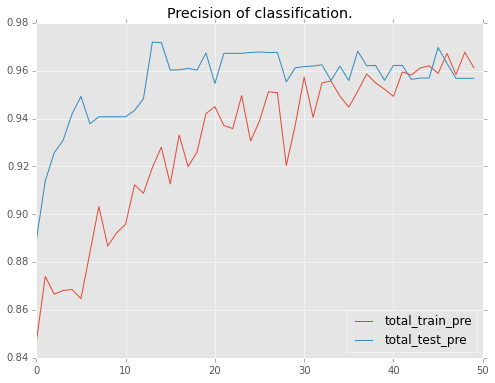

In [22]:
#インプットデータ総数
n_kf = 400
#fold数
n_kf_folds = 4
#trainデータ数
N = n_kf  *  (( n_kf_folds-1)*1.0 / n_kf_folds)
N = int(N)
#testデータ数
N_test = n_kf - N

#cv配列初期化
total_train_loss = [0] * n_epoch
total_train_acc = [0] * n_epoch
total_train_rec = [0] * n_epoch
total_train_pre = [0] * n_epoch
total_test_loss = [0] * n_epoch
total_test_acc = [0] * n_epoch
total_test_rec = [0] * n_epoch
total_test_pre = [0] * n_epoch



kf = KFold(n=n_kf, n_folds=n_kf_folds)

for kf_train_index, kf_test_index in kf:

    #print kf_train_index[perm[0:15]]
    
    #print kf_train_index
    
    # Learning loop
    for epoch in xrange(1, n_epoch+1):
            #print 'epoch', epoch

            # training
            # N個の順番をランダムに並び替える
            perm = np.random.permutation(N)
            sum_accuracy = 0
            sum_loss = 0
            sum_recall = 0
            sum_precision = 0
            total_rec_size = 0
            total_pre_size = 0
            # 0〜Nまでのデータをバッチサイズごとに使って学習
            for i in xrange(0, N, batchsize):
                    x_batch = data[kf_train_index[perm[i:i+batchsize]]]
                    y_batch = target[kf_train_index[perm[i:i+batchsize]]]

                    # 勾配を初期化
                    optimizer.zero_grads()
                    # 順伝播させて誤差と精度を算出
                    loss, acc, rec, pre = forward(x_batch, y_batch)
                    # 誤差逆伝播で勾配を計算
                    loss.backward()
                    optimizer.update()
        
                    sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                    sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize
                    sum_recall += float(cuda.to_cpu(rec.data[0])) * rec.data[1]
                    sum_precision += float(cuda.to_cpu(pre.data[0])) * pre.data[1]
                    total_rec_size += rec.data[1]
                    total_pre_size += pre.data[1]
    
            # 訓練データの誤差と、正解精度を表示
            #print 'train mean loss={}, accuracy={}, recall={}, precision={}'.format(sum_loss / N, sum_accuracy / N, sum_recall / N, sum_precision / N)
                
            total_train_loss[epoch-1] += (sum_loss / (N * n_kf_folds))
            total_train_acc[epoch-1] += (sum_accuracy / (N * n_kf_folds))
            total_train_rec[epoch-1] += (sum_recall / (total_rec_size * n_kf_folds))
            total_train_pre[epoch-1] += (sum_precision / (total_pre_size * n_kf_folds))


            # evaluation
            # テストデータで誤差と、正解精度を算出し汎化性能を確認
            sum_accuracy = 0
            sum_loss     = 0
            sum_recall = 0
            sum_precision = 0
            total_rec_size = 0
            total_pre_size = 0
            for i in xrange(0, N_test, batchsize):
                    x_batch = data[kf_test_index[i:i+batchsize]]
                    y_batch = target[kf_test_index[i:i+batchsize]]

                    # 順伝播させて誤差と精度を算出
                    loss, acc, rec, pre = forward(x_batch, y_batch, train=False)
          
                    #print( cuda.to_cpu(loss.data))
                    #print( cuda.to_cpu(rec.data))
                    #print( cuda.to_cpu(pre.data))
                    sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                    sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize
                    sum_recall += float(cuda.to_cpu(rec.data[0])) * rec.data[1]
                    sum_precision += float(cuda.to_cpu(pre.data[0])) * pre.data[1]
                    total_rec_size += rec.data[1]
                    total_pre_size += pre.data[1]
                

            # テストデータでの誤差と、正解精度を表示
            #print 'test  mean loss={}, accuracy={}, recall={}, precision={}'.format(sum_loss / N_test, sum_accuracy / N_test, sum_recall / N_test, sum_precision / N_test)
            #test_loss.append( sum_loss / N_test)
            #test_acc.append( sum_accuracy / N_test)
            #test_rec.append(sum_recall / N_test)
            #test_pre.append(sum_precision / N_test) 
            
            
            total_test_loss[epoch-1] += (sum_loss / (N_test * n_kf_folds))
            total_test_acc[epoch-1] += (sum_accuracy / (N_test * n_kf_folds))
            total_test_rec[epoch-1] += (sum_recall / (total_rec_size * n_kf_folds))
            total_test_pre[epoch-1] += (sum_precision / (total_pre_size * n_kf_folds))
        

        
            # 学習したパラメーターを保存
            l1_W.append(model.l1.W)
            l2_W.append(model.l2.W)
            l3_W.append(model.l3.W)
            l4_W.append(model.l4.W)
        
            #l1_W = np.append( l1_W, model.l1.W)
        
                      
            #pprint(vars(model.l1))
            #pprint(model.l1.W[0:2])

        
            
# 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_acc)), total_train_acc)
plt.plot(range(len(total_test_acc)), total_test_acc)
plt.legend(["total_train_acc","total_test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()


plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_rec)), total_train_rec)
plt.plot(range(len(total_test_rec)), total_test_rec)
plt.legend(["total_train_rec","total_test_rec"],loc=4)
plt.title("Recall of classification.")
plt.plot()


plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_pre)), total_train_pre)
plt.plot(range(len(total_test_pre)), total_test_pre)
plt.legend(["total_train_pre","total_test_pre"],loc=4)
plt.title("Precision of classification.")
plt.plot()

In [11]:
# 学習したパラメータを出力
#print l1_W

#print l2_W
#print l3_W

l1 = l1_W[0].T
l2 = l2_W[0].T
l3 = l3_W[0].T
l4 = l4_W[0].T


param = l1.dot(l2).dot(l3).dot(l4)

print param

[[ -1.12955451   1.22824311]
 [-10.1351862    8.81788445]
 [ -4.75805569   4.07091665]
 [  0.50168824  -0.26521993]
 [ -1.82621729   1.53926611]
 [ -2.06621075   1.48655665]
 [ -0.68478382   0.80154461]
 [  0.9721148   -0.6993469 ]
 [-19.12200737  16.40470886]
 [-43.12466431  37.87928009]
 [ -3.7563107    3.06845331]
 [ -3.87720203   3.26878977]
 [ -3.46961355   3.32651782]
 [ -7.88303661   6.9858675 ]
 [-30.58934784  26.61063766]]


In [36]:
print total_train_acc

[0.8474999944368998, 0.874166662991047, 0.8841666628917059, 0.8883333290616672, 0.9041666626930237, 0.9024999956289927, 0.9233333279689153, 0.9233333299557368, 0.9299999982118607, 0.9408333281675975, 0.9416666636864344, 0.9458333273728688, 0.9524999976158142, 0.9374999970197677, 0.9466666628917058, 0.9516666620969771, 0.9508333285649617, 0.947499997417132, 0.9549999972184499, 0.9499999970197677, 0.9574999948342641, 0.9608333289623261, 0.962499996026357, 0.9608333289623261, 0.9583333263794581, 0.968333328763644, 0.9608333299557368, 0.9666666607062022, 0.9658333291610082, 0.9641666620969773, 0.9616666595141092, 0.9741666624943415, 0.9741666615009308, 0.9816666622956594, 0.9633333285649617, 0.9741666634877524, 0.9699999968210857, 0.976666663090388, 0.9741666615009307, 0.9683333287636439, 0.975833327571551, 0.9741666624943417, 0.9741666624943415, 0.9758333295583725, 0.9749999950329463, 0.9691666622956594, 0.977499994635582, 0.9741666615009308, 0.9741666624943415, 0.9774999966224034]
